Starting web scraping...
Scraping https://www.youtube.com/@GeeksforGeeksVideos/videos...
Scrolling... (1/5)
Scrolling... (2/5)
Scrolling... (3/5)
Scrolling... (4/5)
Scrolling... (5/5)
Web scraping finished.
Found 30 videos.
Writing data to file.xlsx...
Data written successfully.
Starting data preprocessing...
Data preprocessing finished.
Starting text preprocessing...


100%|██████████| 30/30 [00:00<00:00, 34417.16it/s]

Text preprocessing finished.
Generating word cloud...


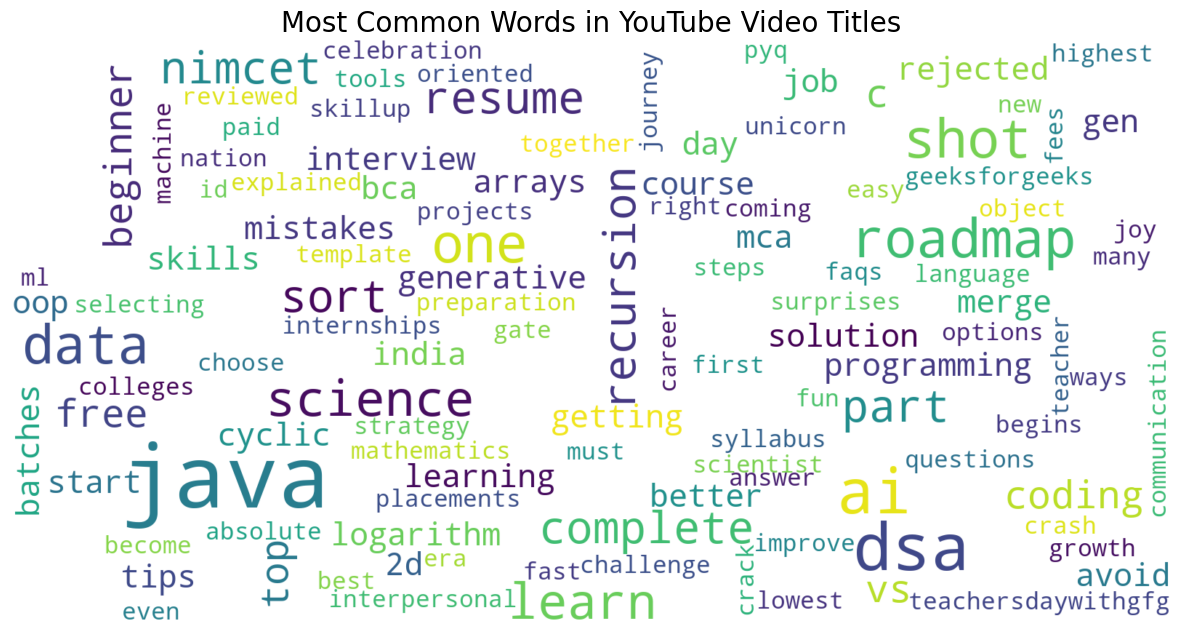

Visualization complete.


In [1]:
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import xlsxwriter
import pandas as pd
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# =============================================================================
# 1. WEB SCRAPING SECTION
# =============================================================================

print("Starting web scraping...")

urls = ['https://www.youtube.com/@GeeksforGeeksVideos/videos']


try:
    driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
except Exception as e:
    print(f"Could not initialize Chrome Driver. Please ensure Chrome is installed.")
    print(f"Error: {e}")
    exit()

times_to_scroll = 5
for url in urls:
    driver.get(url)
    print(f"Scraping {url}...")

    scroll_count = 0
    while scroll_count < times_to_scroll:
        print(f"Scrolling... ({scroll_count + 1}/{times_to_scroll})")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        scroll_count += 1

    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')

driver.quit()
print("Web scraping finished.")

video_containers = soup.find_all('ytd-rich-item-renderer')

t = []
v = []
d = []

for video in video_containers:
    title_element = video.find('a', id='video-title-link')
    title = title_element.get('title') if title_element else 'No Title'

    meta_elements = video.find_all('span', class_='inline-metadata-item')
    view_text = '0 views'
    if len(meta_elements) > 0 and 'view' in meta_elements[0].text:
        view_text = meta_elements[0].text

    duration_element = video.find('span', class_='style-scope ytd-thumbnail-overlay-time-status-renderer')
    duration = duration_element.text.strip() if duration_element else '0:00'

    t.append(title)
    v.append(view_text)
    d.append(duration)


if len(t) == 0:
    print("\nError: No videos were found. The script cannot proceed.")
    print("This might be due to a change in YouTube's website structure or a network issue.")
    exit()

print(f"Found {len(t)} videos.")

print("Writing data to file.xlsx...")
with xlsxwriter.Workbook('file.xlsx') as workbook:
    worksheet = workbook.add_worksheet()
    worksheet.write(0, 0, "Title")
    worksheet.write(0, 1, "Views")
    worksheet.write(0, 2, "Duration")

    row = 1
    for title, view, dura in zip(t, v, d):
        worksheet.write(row, 0, title)
        worksheet.write(row, 1, view)
        worksheet.write(row, 2, dura)
        row += 1
print("Data written successfully.")

# =============================================================================
# 2. DATA PREPROCESSING SECTION
# =============================================================================
print("Starting data preprocessing...")
data = pd.read_excel('file.xlsx')


data['Views'] = data['Views'].astype(str).str.replace(" views", "")
new_views = []
for view_str in data['Views']:
    view_str = str(view_str).strip()
    if 'K' in view_str:
        num = float(view_str.replace('K', '')) * 1000
    elif 'M' in view_str:
        num = float(view_str.replace('M', '')) * 1000000
    else:
        num = float(view_str) if view_str.replace('.', '', 1).isdigit() else 0
    new_views.append(num)
data['Views'] = new_views
data['Views'] = data['Views'].astype(int)


new_duration_seconds = []
for i in data['Duration']:
    parts = i.strip().split(':')
    if 'SHORTS' in i.upper() or len(parts) == 1:
        new_duration_seconds.append(30)
    elif len(parts) == 2:
        seconds = int(parts[0]) * 60 + int(parts[1])
        new_duration_seconds.append(seconds)
    elif len(parts) == 3:
        seconds = int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        new_duration_seconds.append(seconds)
data['DurationInSeconds'] = new_duration_seconds

duration_categories = []
for seconds in data['DurationInSeconds']:
    if seconds <= 60:
        duration_categories.append('Shorts')
    elif 61 <= seconds <= 900:
        duration_categories.append('Medium Videos (1-15 min)')
    elif 901 <= seconds <= 3600:
        duration_categories.append('Long Videos (15-60 min)')
    else:
        duration_categories.append('Very Long Videos (>1 hr)')
data['DurationCategory'] = duration_categories

print("Data preprocessing finished.")
data.head()

# =============================================================================
# 3. TEXT PREPROCESSING SECTION
# =============================================================================
print("Starting text preprocessing...")
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')


def preprocess_text(text_data):
    preprocessed_text = []
    stop_words = set(stopwords.words('english'))
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        tokens = [token.lower() for token in str(sentence).split() if token.lower() not in stop_words]
        preprocessed_text.append(' '.join(tokens))
    return preprocessed_text


data['Title'] = preprocess_text(data['Title'].values)
print("Text preprocessing finished.")

# =============================================================================
# 4. DATA VISUALIZATION SECTION
# =============================================================================
print("Generating word cloud...")

consolidated = ' '.join(word for word in data['Title'].astype(str))


if not consolidated.strip():
    print("\nError: No words left to generate a word cloud after preprocessing.")
    print("This could happen if all video titles consisted only of stopwords.")
else:
    wordCloud = WordCloud(width=1600, height=800, background_color='white', random_state=21, max_font_size=120,
                          collocations=False)
    wordCloud.generate(consolidated)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in YouTube Video Titles', fontsize=20)
    plt.show()

print("Visualization complete.")

